In [1]:
import healpy as hp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
hp.disable_warnings()

In this third notebook, we will handle a case of not-uniform and partial sky coverage.

In [2]:
# Number based on Simons Observatory SAT UHF1 array of detectors

net = 10. * u.Unit("uK * sqrt(s)")

5 years with a efficiency of 20%:

In [3]:
integration_time_total = 5 * u.year * .2

## Download a hitmap

We can download a simulated hitmap for a Simons Observatory band, for now however, we assume a uniform coverage.

In [4]:
hitmap_url = "https://portal.nersc.gov/project/sobs/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz"

In [5]:
!wget $hitmap_url

--2020-12-11 10:35:42--  https://portal.nersc.gov/project/sobs/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.24, 128.55.206.26
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3212515 (3.1M) [application/x-gzip]
Saving to: ‘ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz.10’

ST0_UHF1_01_of_20.n 100%[===================>]   3.06M  --.-KB/s    in 0.1s    

2020-12-11 10:35:43 (30.0 MB/s) - ‘ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz.10’ saved [3212515/3212515]



In [6]:
hitmap = hp.read_map("ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz")

In [7]:
hitmap /= hitmap.max()

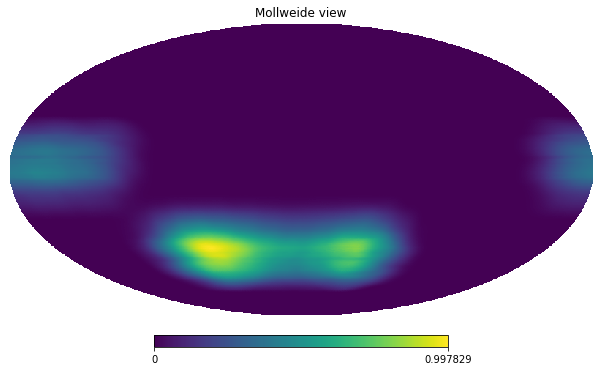

In [8]:
hp.mollview(hitmap)

## Generic partial sky survey

We have now a sky coverage which not uniform

In [9]:
nside = 512
npix = hp.nside2npix(nside)

In [10]:
hitmap = hitmap / hitmap.sum() * integration_time_total.to(u.s)

In [11]:
hitmap_plot = hitmap.value.copy()
hitmap_plot[hitmap == 0] = hp.UNSEEN

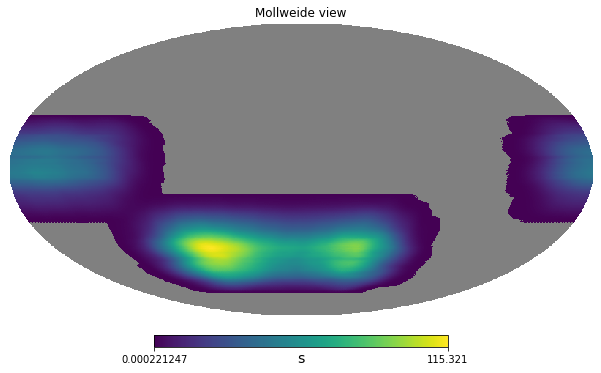

In [12]:
hp.mollview(hitmap_plot, unit=hitmap.unit)

In [13]:
variance_per_pixel = \
    (net**2 / hitmap).decompose()

/home/zonca/zonca/p/software/healpy/healpyvenv/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [14]:
variance_per_pixel[np.isinf(variance_per_pixel)] = 0

In [15]:
m = np.random.normal(scale = np.sqrt(variance_per_pixel),
                     size=len(variance_per_pixel)) * np.sqrt(variance_per_pixel).unit

In [16]:
variance_per_pixel.max()

<Quantity 4.51983001e-07 K2>

In [17]:
m.value[hitmap==0] = hp.UNSEEN

In [18]:
m = m.to(u.uK)

In [19]:
m.value[hitmap==0] = hp.UNSEEN

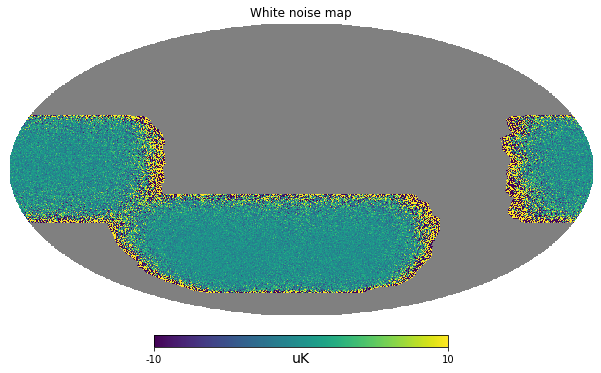

In [20]:
hp.mollview(m, unit=m.unit, min=-10, max=10, title="White noise map")

## Power spectrum

In [21]:
sky_fraction = hp.mask_good(m).sum()/len(m)

In [22]:
cl = hp.anafast(m) / sky_fraction

In [23]:
cl[100:].mean()

0.0044214096150382255

In [24]:
pixel_area = hp.nside2pixarea(nside)

In [25]:
white_noise_cl = (variance_per_pixel[variance_per_pixel>0].mean() * pixel_area).to(u.uK**2)

In [26]:
white_noise_cl_uniform = 1.5341266e-5 * u.uK**2

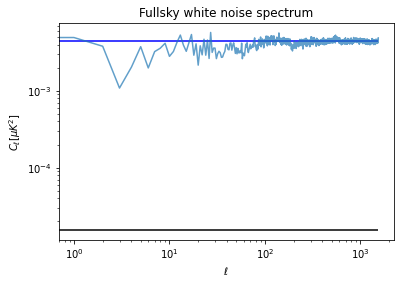

In [27]:
plt.figure(figsize=(6,4))
plt.loglog(cl, label="Map power spectrum", alpha=.7)
plt.hlines(white_noise_cl.value, 0, len(cl), color="blue",
           label="White noise level")
plt.hlines(white_noise_cl_uniform.value, 0, len(cl),
           label="White noise level uniform")
plt.title("Fullsky white noise spectrum")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$");

In [28]:
sky_fraction

0.38526121775309247

## Pixel weighting in the power spectrum

When we have un-uniform noise across the map, it is advantageous to weight the pixels differently before taking the power spectrum in order to downweight the noisiest pixels.

If we weight by the square root of the number of hits per pixels, then we are normalizing the standard deviation per pixel to be the same across all pixels, in fact
we recover the same noise level we had when we were spreading the hits uniformly in the sky patch.

However, the optimal is actually to weight by the inverse variance, which means to weight by the hitmap, to estimate the value expected for this we need to weight the variance by the square of the hitmap (variance is in power so weighting the map by a quantity is equivalent to weighting the variance by its square).

In [29]:
cl_apodized = hp.anafast(m * np.sqrt(hitmap)) / np.mean(hitmap)

In [30]:
cl_apodized_inv_variance = hp.anafast(m * hitmap) / np.mean(hitmap**2)

In [31]:
cl_apodized_inv_variance[100:].mean() / white_noise_cl_uniform.value

<Quantity 0.49056891 1 / s2>

In [32]:
white_noise_cl / white_noise_cl_uniform

<Quantity 291.0895877>

In [33]:
white_noise_cl

<Quantity 0.00446568 uK2>

In [34]:
white_noise_cl_uniform

<Quantity 1.5341266e-05 uK2>

In [35]:
np.average(variance_per_pixel, weights=hitmap) * pixel_area * 1e12

<Quantity 1.53412656e-05 K2>

In [36]:
white_noise_cl_inv_variance = np.average(variance_per_pixel, weights=hitmap**2) * pixel_area * 1e12

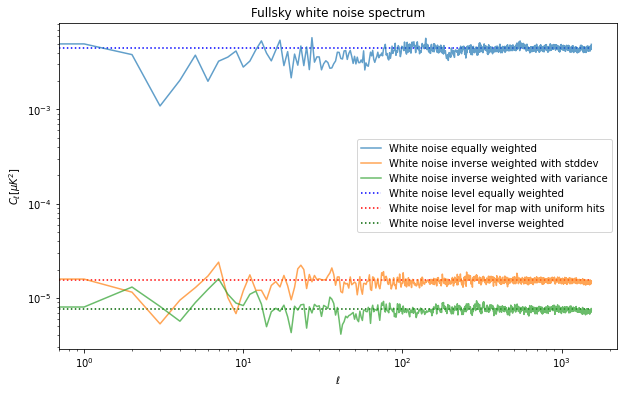

In [37]:
plt.figure(figsize=(10,6))
plt.loglog(cl, label="White noise equally weighted", alpha=.7)
plt.hlines(white_noise_cl.value, 0, len(cl), color="blue", ls=":",
           label="White noise level equally weighted")

plt.loglog(cl_apodized, label="White noise inverse weighted with stddev", alpha=.7)

plt.hlines(white_noise_cl_uniform.value, 0, len(cl), color="red", ls=":",
           label="White noise level for map with uniform hits")

plt.loglog(cl_apodized_inv_variance, label="White noise inverse weighted with variance", alpha=.7)
plt.hlines(white_noise_cl_inv_variance.value, 0, len(cl), color="darkgreen", ls=":",
           label="White noise level inverse weighted")
plt.title("Fullsky white noise spectrum")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$");